# TMDB Network

This notebook contains recipe to construct a heterogeneous network based on the fetched TMDB dataset.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Input Data

[The Movie Database (TMDB)](https://www.themoviedb.org/) is a popular online database and community platform that provides a vast collection of information about movies, TV shows, and other related content. We collected metadata about more than 7500 of the most popular action, romance, thriller and animation English movies from [TMDB's public API](https://developer.themoviedb.org/docs) on May 31, 2024. After meticulous data cleaning, we finally obtain 7,505 movies, 13,016 actors, and 3,891 directors.


In [2]:
movies = pd.read_csv('TMDB.csv')
movies['actor'] = movies['actor'].apply(eval)
movies['director'] = movies['director'].apply(eval)
print('Number of movies:', movies.shape[0])
movies.head()

Number of movies: 7505


id                            title  \
0  199753  Tom and Jerry's Giant Adventure   
1    9560             A Walk in the Clouds   
2   10875          The Fabulous Baker Boys   
3   67609         Three Blind Mouseketeers   
4   24021       The Twilight Saga: Eclipse   

                                            overview      genre release_date  \
0  Tom And Jerry are among the last animals livin...  Animation   2013-08-04   
1  World War II vet Paul Sutton falls for a pregn...    Romance   1995-05-27   
2  The lives of two struggling musicians, who hap...    Romance   1989-10-13   
3  As the title implies, the three blind mice are...  Animation   1936-09-26   
4  Bella once again finds herself surrounded by d...    Romance   2010-06-23   

                                               actor  \
0  [80416, 86434, 60739, 5129, 1065, 31531, 11444...   
1  [7353, 62595, 3753, 85869, 6862, 152943, 6384,...   
2  [7906, 8354, 43364, 152963, 1160, 57992, 1229,...   
3                                      [31771, 5462]   
4  [84224, 84225, 45827, 121868, 87310, 1475835, ...   

                                     director  
0                     [23683, 1447452, 92317]  
1                            [77162, 1377239]  
2                    [2226, 2571810, 1966431]  
3                              [564041, 5446]  
4  [2045537, 1393423, 27571, 2476949, 113019]

In [3]:
actor_id_map = {}
idx = 0
for actors in movies['actor']:
    for actor in actors:
        if actor not in actor_id_map:
            actor_id_map[actor] = idx
            idx += 1
len(actor_id_map)

13016

In [4]:
director_id_map = {}
idx = 0
for directors in movies['director']:
    for director in directors:
        if director not in director_id_map:
            director_id_map[director] = idx
            idx += 1
len(director_id_map)

3891

## Graph Construction

```mermaid
---
title: The TMDB HIN
---
flowchart LR
    Movie["<b>Movie</b><br>7,505 nodes<br>4 labels"]
    Actor["<b>Actor</b><br>13,016 nodes"]
    Director["<b>Director</b><br>3,891 nodes"]
    Actor --"<b>performs</b><br>86,517 edges"--- Movie
    Director --"<b>directs</b><br>18,341 edges"--- Movie
```

In [5]:
data = {}

### Movie-Actor Links

In [6]:
movie_ids = []
actor_ids = []
for movie_id in range(len(movies)):
    actors = movies.iloc[movie_id]['actor']
    for actor in actors:
        movie_ids.append(movie_id)
        actor_ids.append(actor_id_map[actor])
    
movie_ids = np.array(movie_ids, dtype=np.int16)
actor_ids = np.array(actor_ids, dtype=np.int16)
print('Number of movie-actor links:', movie_ids.shape[0])
data['movie-actor'] = (movie_ids, actor_ids)

Number of movie-actor links: 86517


### Movie-Director Links

In [7]:
movie_ids = []
director_ids = []
for movie_id in range(len(movies)):
    directors = movies.iloc[movie_id]['director']
    
    for director in directors:
        movie_ids.append(movie_id)
        director_ids.append(director_id_map[director])
    
movie_ids = np.array(movie_ids, dtype=np.int16)
director_ids = np.array(director_ids, dtype=np.int16)
print('Number of movie-director links:', movie_ids.shape[0])
data['movie-director'] = (movie_ids, director_ids)

Number of movie-director links: 18341


### Labels

There are a total of 19 movie genres in TMDB. We selected four genres with low intercorrelation as our ground truth labels. Note that one movie usually has multiple genres. To improve label quality, we only collect movies whose genres just include one of {action, romance, thriller, animation}.


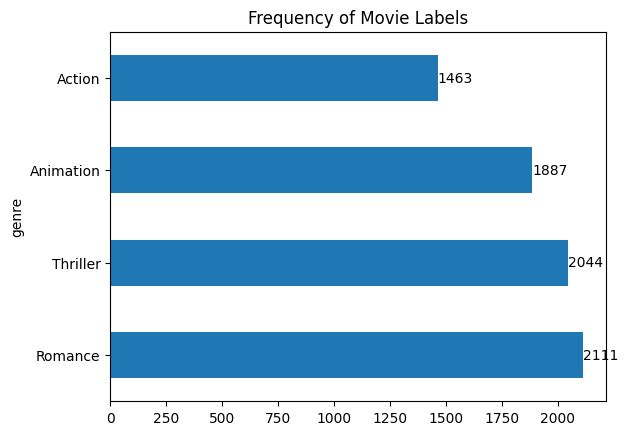

In [8]:
ax = movies['genre'].value_counts().plot.barh()
ax.bar_label(ax.containers[0])
plt.title('Frequency of Movie Labels')
plt.show()

In [9]:
movie_label_ids = {'Action': 0, 'Romance': 1, 'Thriller': 2,  'Animation': 3}

movie_labels = movies['genre'].apply(lambda g: movie_label_ids[g]).values
movie_labels = movie_labels.astype(np.int8)
data['movie_labels'] = movie_labels

## Node Features

We generate embeddings as features for each node in the graph. Node embeddings are generated by passing the movie overviews through a Sentence-BERT model and obtaining a 384-embedding vector for each movie node.


According to [Sentence-Transformers docs](https://www.sbert.net/docs/pretrained_models.html), the **all-MiniLM-L6-v2** model provides the best quality. So we use it to generate node features.

all-MiniLM-L6-v2

Description:	All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs.
Base Model:	nreimers/MiniLM-L6-H384-uncased
Max Sequence Length:	256
Dimensions:	384
Normalized Embeddings:	true
Suitable Score Functions:	dot-product (util.dot_score), cosine-similarity (util.cos_sim), euclidean distance
Size:	80 MB
Pooling:	Mean Pooling
Training Data:	1B+ training pairs. For details, see model card.
Model Card:	https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2


In [10]:
import torch
from sentence_transformers import SentenceTransformer

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('../sentence-transformers/all-MiniLM-L6-v2', device=device)
model

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [11]:
text = movies['overview']

In [12]:
feats = model.encode(text, batch_size=4096, show_progress_bar=True, convert_to_numpy=True)
data['movie_feats'] = feats

Batches: 100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


In [13]:
movie_years = movies['release_date'].apply(lambda s: int(s[:4]))
movie_years = movie_years.values.astype(np.int16)
data['movie_years'] = movie_years

In [14]:
data

{'movie-actor': (array([   0,    0,    0, ..., 7504, 7504, 7504], dtype=int16),
  array([    0,     1,     2, ..., 11870,  1733, 11794], dtype=int16)),
 'movie-director': (array([   0,    0,    0, ..., 7503, 7503, 7504], dtype=int16),
  array([   0,    1,    2, ..., 3423,  966, 2890], dtype=int16)),
 'movie_labels': array([3, 1, 1, ..., 1, 1, 2], dtype=int8),
 'movie_feats': array([[ 0.00635284,  0.00649689,  0.01250827, ...,  0.06342042,
         -0.01747945,  0.0134356 ],
        [-0.14075027,  0.02825641,  0.02670695, ..., -0.12270895,
          0.08417314,  0.02486392],
        [ 0.00014208, -0.02286632,  0.00615967, ..., -0.03311544,
          0.04735276, -0.07458566],
        ...,
        [ 0.01835816,  0.07484645, -0.08099765, ..., -0.00150019,
          0.01669764,  0.00456595],
        [-0.00821487, -0.10434289,  0.01928608, ..., -0.06343049,
          0.05060194, -0.04229118],
        [-0.06465845,  0.13461556, -0.01640793, ..., -0.06274845,
          0.04002513, -0.00751513]

In [15]:
with open('tmdb.pkl', 'wb') as f:
    pickle.dump(data, f)